In [1]:
import numpy as np 
import pandas as pd
import pickle
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path 
import re 
# get utils for thresholds
from src import util_analysis 
from src import util_process_prolific as util_process
import importlib
from tqdm.auto import tqdm
import multiprocessing as mp
from scipy import stats 

### Run stats on human results 
from statsmodels.stats.anova import AnovaRM
import statsmodels.api as sm
from statsmodels.formula.api import ols

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
# So that we can edit the text in illustrator
matplotlib.rcParams.update({'font.size': 10})
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['svg.fonttype'] = 'none'
fig_out_dir = Path("final_figures/figure_4")
fig_out_dir.mkdir(exist_ok=True, parents=True)


In [2]:
# util_analysis.get_model_name('word_task_v10_backbone_word_config')

# Load pre-computed human threshold data

In [3]:
path_to_human_results = Path('final_results_dir')
human_thresh_df = pd.read_pickle(path_to_human_results / 'summary_2024_human_threshold_results_avg_sex_cond_rel_part_max.pdpkl')
human_thresh_df_per_sex = pd.read_pickle(path_to_human_results / 'summary_2024_human_threshold_results_split_by_sex_cond_rel_part_max.pdpkl')
raw_human_data = pd.read_pickle(path_to_human_results / 'raw_participant_threshold_data.pdpkl')

##### Load human data for permutation test and stats 

In [4]:
N = 33

human_thresh_df_summary = human_thresh_df.groupby(['elev_delta', 'azim_delta']).agg({'threshold':['mean', 'std']}).reset_index()
# # flatten multiindex
human_thresh_df_summary.columns = ['elev_delta', 'azim_delta', 'threshold', 'threshold_std']


human_thresh_df_summary_per_sex = human_thresh_df_per_sex.groupby(['elev_delta', 'azim_delta', 'sex_cond']).agg({'threshold':['mean', 'std']}).reset_index()
# # flatten multiindex
human_thresh_df_summary_per_sex.columns = ['elev_delta', 'azim_delta', 'sex_cond', 'threshold', 'threshold_std']

## Plot human thresholds

Text(0.5, 1.05, 'Huamn thresholds (N=33)')

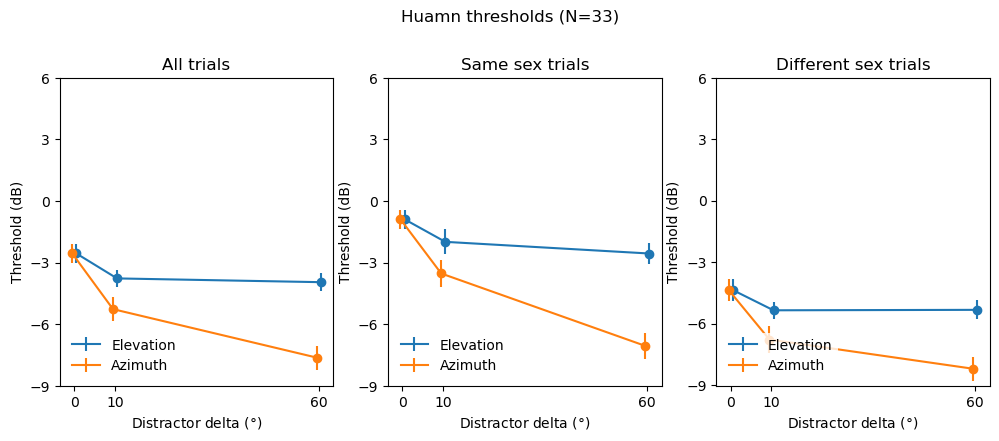

In [5]:
#### Per sex 
fig, ax = plt.subplots(1,3,figsize=(12,4))


sex_conds = ['all', 'same', 'different']
for ix, sex_cond in enumerate(sex_conds):
    if ix == 0:
        elev_data = human_thresh_df_summary[human_thresh_df_summary.azim_delta == 0]
        azim_data = human_thresh_df_summary[human_thresh_df_summary.elev_delta == 0]
        elev_to_plot = elev_data
        azim_to_plot = azim_data
    else: 
        elev_data = human_thresh_df_summary_per_sex[human_thresh_df_summary_per_sex.azim_delta == 0]
        azim_data = human_thresh_df_summary_per_sex[human_thresh_df_summary_per_sex.elev_delta == 0]
        elev_to_plot = elev_data[elev_data.sex_cond == sex_cond]
        azim_to_plot = azim_data[azim_data.sex_cond == sex_cond]

    ax[ix].errorbar(data=elev_to_plot, x=elev_to_plot.elev_delta + 0.5, y='threshold', yerr='threshold_std', fmt='o-', label='Elevation')
    ax[ix].errorbar(data=azim_to_plot, x=azim_to_plot.azim_delta - 0.5, y='threshold', yerr='threshold_std', fmt='o-', label='Azimuth')

    ax[ix].legend(loc='lower left', markerscale=0)
    ax[ix].get_legend().get_frame().set_linewidth(0.0)

    ax[ix].set_xlabel('Distractor delta ($\degree$)')
    ax[ix].set_ylabel('Threshold (dB)')
    ax[ix].set_xticks([0, 10, 60])
    ax[ix].set_yticks(np.arange(-9, 7, 3))
    if ix == 0:
        ax[ix].set_title("All trials")
    else:
        ax[ix].set_title(f"{sex_cond.title()} sex trials")

plt.suptitle(f"Huamn thresholds (N={N})", y=1.05)

## Load model data and meta files

In [6]:
room_manifest = pd.read_pickle('/om2/user/msaddler/spatial_audio_pipeline/assets/brir/eval/manifest_room.pdpkl')
# for tuple_ in room_manifest.itertuples():
#     print(tuple_)
#     break
room_material_map = {}
for row in room_manifest.itertuples():
    wall1 = row.material_x0[0].split(',')[0]
    wall2 = row.material_y1[0].split(',')[0]
    if wall1 == wall2:
        wall_str = f"{wall1} walls"
    else:
        wall_str = f"{wall1} and {wall2} walls"

    floor = row.material_z0[0].split(',')[0]
    ceiling = row.material_z1[0].split(',')[0]
    name_str = f"{wall_str} \n {floor} floor \n {ceiling} ceiling"

    if row.index_room in [5, 6]:
        name_str = 'Alternate speaker room'
    if row.index_room in [6, 8]:
        name_str += ' \n head rotated'
    else:
        head_rotated = ''
    if 'Anechoic' in name_str:
        name_str = "Anechoic"
    room_material_map[row.index_room] = name_str
# room_material_map = {row.index_room: f"{row.material_x0[0].split(',')[0]} and \n {row.material_y1[0].split(',')[0]} walls \n {row.material_z0[0].split(',')[0]} floor \n {row.material_z1[0].split(',')[0]} ceiling" for row in room_manifest.itertuples()}
# room_material_map[5] = 'standard speaker room'
room_material_map

{0: 'Anechoic',
 1: 'Wood panelling on glass fiber blanket walls \n Carpet on foam rubber padding floor \n Highly absorptive panels ceiling',
 2: 'Brick walls \n Wood parquet on concrete floor \n Plaster ceiling',
 3: 'Fiberglass wall treatment walls \n Linoleum floor \n Acoustic tiles ceiling',
 4: 'Concrete walls \n Linoleum floor \n Acoustic tiles ceiling',
 5: 'Alternate speaker room',
 6: 'Alternate speaker room \n head rotated',
 7: 'Fiberglass wall treatment walls \n Linoleum floor \n Acoustic tiles ceiling',
 8: 'Fiberglass wall treatment walls \n Linoleum floor \n Acoustic tiles ceiling \n head rotated'}

In [7]:
import pickle 

manifest_path = "binaural_test_manifests/human_array_exmpt_sim_v02_only_human_locs_w_noise_min_reverb_mit_room_v02.pkl"
with open(manifest_path, "rb") as f: 
    manifest = pickle.load(f)
    

In [8]:
manifest_df  = pd.DataFrame(manifest.values())
# manifest_df

In [9]:
# spkr_room_manifest = pd.read_pickle('/om2/user/msaddler/spatial_audio_pipeline/assets/brir/mit_bldg46room1004/manifest_room.pdpkl')
spkr_room_manifest = pd.read_pickle('/om2/user/imgriff/spatial_audio_pipeline/assets/brir/mit_bldg46room1004_min_reverb/manifest_room.pdpkl')

In [10]:
# output_paths

In [11]:

output_paths = list(Path(f"binaural_eval/simulate_2024_human_threshold_experiment_v02_30_dB_pink_noise_min_verb_mit46_1004").glob("*/*v10*.pkl"))
output_paths += list(Path(f"binaural_eval/simulate_2024_human_threshold_experiment_v02_30_dB_pink_noise_min_verb_mit46_1004").glob("*/*50Hz_cutoff*.pkl"))
# output_paths = list(Path(f"binaural_eval/simulate_2024_human_threshold_experiment_v02_cue_noise").glob("*/*.pkl"))
stim_manifest_df = pd.read_pickle('/om/user/imgriff/datasets/human_word_rec_SWC_2024/full_cue_target_distractor_df_w_meta.pdpkl')


word_class_map = pickle.load( open("/om2/user/imgriff/datasets/commonvoice_9/en/cv_800_word_label_to_int_dict.pkl", "rb" )) 
ix_to_word = {v:k for k,v in word_class_map.items()}

remap_azim = lambda azim: 360 - azim if azim > 180 else 0 - azim 

results_dfs = []

gend_map = {True:'same', False:'different'}

for path in output_paths:
    # if not any([model in path.stem for model in wanted_models]):
    #     continue
    # if not 'v09' in str(path):
    #     continue
    # if 'modulated' in path.stem:
    #     continue 
    # if not 'mitb46' in path.stem:
    #     continue 
    # if 'white_noise' in path.as_posix():
    #     continue
    # if 'texture' in path.as_posix():
    #     continue

    res_dict = pickle.load(open(path, 'rb'))
    to_track = {key:val for key,val in res_dict.items() if key != 'textures'}

    df = pd.DataFrame.from_dict(to_track)
    # break
    df.rename(columns={"results": "accuracy"}, inplace=True)
    df['model'] = util_analysis.get_model_name(path.parent.stem)

    df.loc[df.index.values, ['word', 'distractor_word','sex_cond']] = stim_manifest_df.loc[df.stim_ix_list.values, ['word', 'distractor_word','sex_cond']].values
    df['target_word'] = df['true_word_int'].map(ix_to_word)
    df['pred_word'] = df['preds'].map(ix_to_word)
    df['correct'] = (df['true_word_int'] == df['preds']).astype('int')
    df['str_confusions'] = df[['pred_word', 'distractor_word']].apply(lambda x: 1 if x.pred_word in x.distractor_word else 0, axis=1)
    ## Get SNR level from path
    if 'clean' in path.stem:
        snr = 'clean'
    else:
        snr = int(re.search('(-?\d+)_SNR', path.stem).group(0).strip('_SNR'))
    df['snr'] = snr 
    ## Get texture leve lfrom path 
    if "no_texture" in path.stem:
        texture_level = 'no_texture'
    
    elif 'texture' in path.stem: 
        texture_level = re.search('(-?\d+)dB_bg_texture',path.stem).group(0).split('dB')[0]
    elif 'pink_noise' in path.stem:
        texture_level = re.search('(-?\d+)dB_bg_pink_noise',path.stem).group(0).split('dB')[0]


    df['texture_level'] = texture_level
    df["target_azim"], df["target_elev"] = path.stem.split('target_loc_')[1].split('_distract_loc_')[0].split('_')
    df["distractor_azim"], df["distractor_elev"] = path.stem.split('_distract_loc_')[1].split('_')[:2]
    # # map azim to 0-180
    df['target_azim'] = df['target_azim'].astype(int).apply(remap_azim)
    df['distractor_azim'] = df['distractor_azim'].astype(int).apply(remap_azim)
    df['target_elev'] = df['target_elev'].astype(int)
    df['distractor_elev'] = df['distractor_elev'].astype(int)
    df['room_ix'] = int(re.search('room(-?\d+)', path.stem).group(0).strip('room'))
    df['room_type'] = re.search('SNR_(.*?)_room', path.stem).group(0).split('SNR_')[-1].split("_room")[0]
    df['n_distractors'] = 1 if '1_distractor' in path.stem else 2
    df['test_set'] = 'all_stim' if 'all_stim' in path.stem else 'subset'
    results_dfs.append(df)

results = pd.concat(results_dfs)

In [12]:
results.model.value_counts()

model
Early-only              117120
Late-only               117120
Feature-gain alt v1     117120
Feature-gain alt v2     117120
Backbone                117120
Feature-gain main       117120
50Hz cutoff             117120
Feature-gain alt v10    115168
Feature-gain alt v4     115168
Feature-gain alt v8     115168
Feature-gain alt v9     115168
Baseline CNN            115168
Feature-gain alt v6     113216
Feature-gain alt v7     113216
Feature-gain alt v12    111264
Name: count, dtype: int64

In [13]:
results.loc[results.room_type.str.contains('eval'), 'room_str'] = results.loc[results.room_type == 'eval', 'room_ix'].map(room_material_map)

results.loc[results.room_type.str.contains('mitb46'), 'room_str'] = 'Normal speaker array'
results.loc[results.room_type.str.contains('mitb46'), 'room_ix'] = 9 # use n from diff room notebook

results.loc[results.room_type.str.contains('reverb'), 'room_str'] = 'Min. reverb speaker array'
results.loc[results.room_type.str.contains('reverb'), 'room_ix'] = 10 # use n from diff room notebook


In [14]:
grouped_model_results = results.groupby(['model', 'target_azim', 'target_elev', 'distractor_azim', 'test_set',  'texture_level',
                                   'distractor_elev', 'sex_cond', 'snr', 'n_distractors', 'room_str']).agg({'accuracy':['mean', 'sem'],
                                                                                                                     'confusions':['mean', 'sem']}).reset_index()
# flatten multiindex
grouped_model_results.columns = ['_'.join(col).strip() for col in grouped_model_results.columns.values]
# remove trailing underscore
grouped_model_results.columns = [col[:-1] if col[-1] == '_' else col for col in grouped_model_results.columns.values]



In [15]:
grouped_model_results['distractor_elev_delta'] = (grouped_model_results['target_elev'] - grouped_model_results['distractor_elev']).abs()

In [16]:
grouped_model_results.texture_level.unique()

array(['30'], dtype=object)

<Figure size 640x480 with 0 Axes>

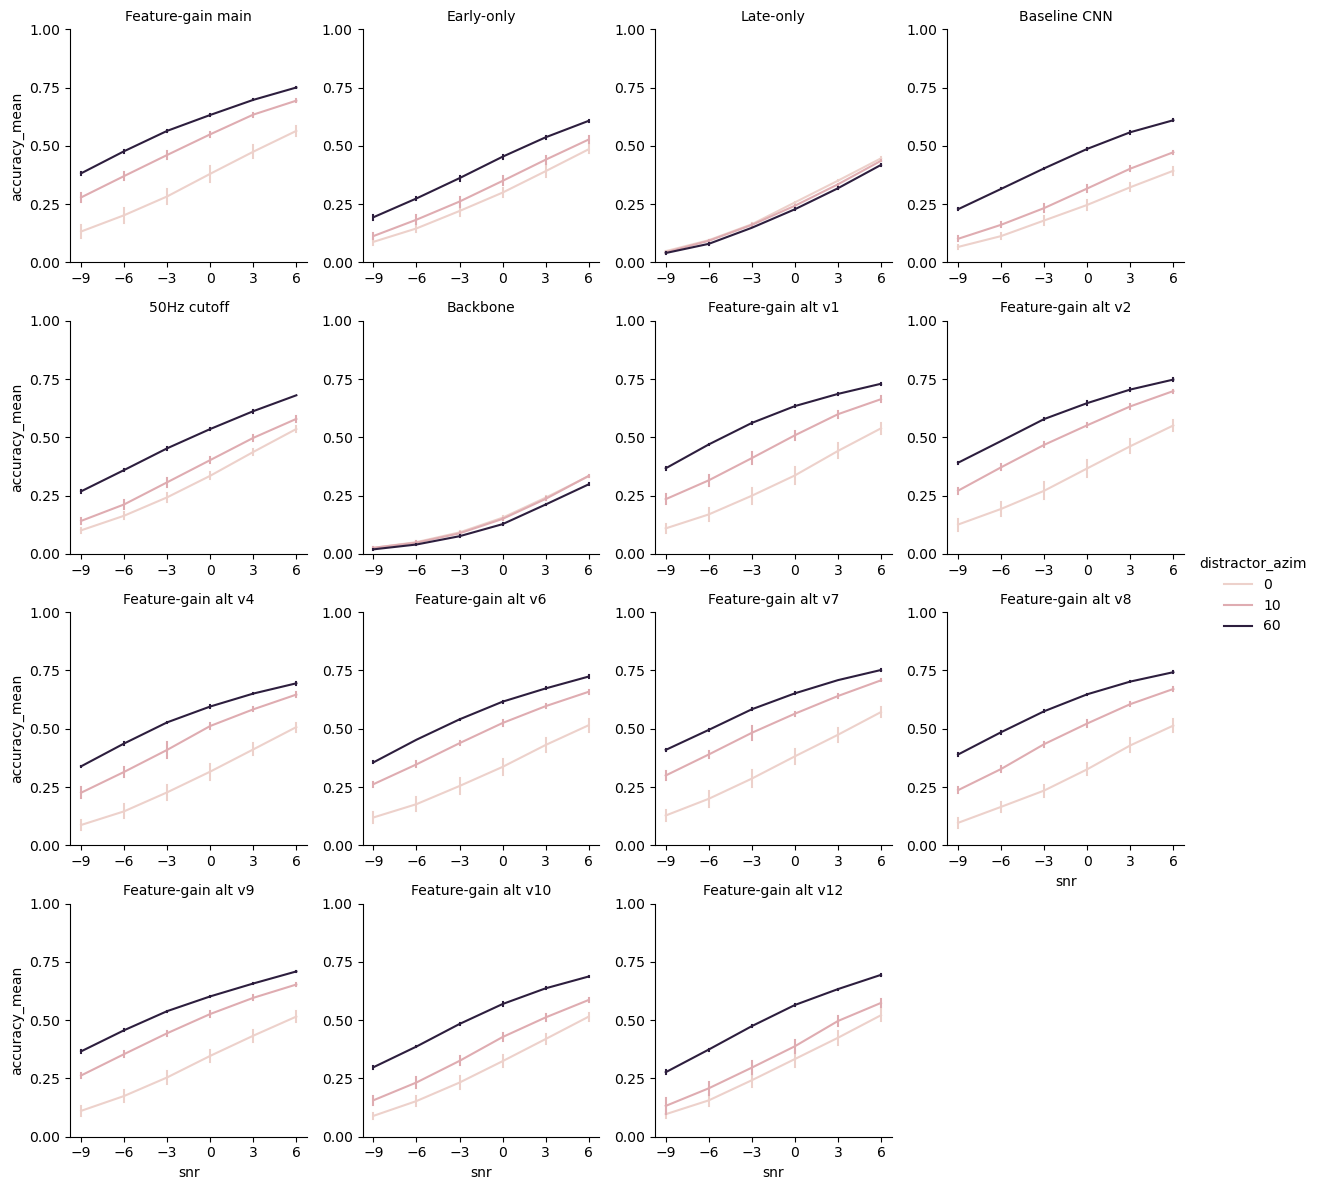

In [17]:
import re
azim_to_plot = grouped_model_results[
                        (grouped_model_results.distractor_elev_delta.eq(0 ))
                            & (grouped_model_results.distractor_azim.abs().isin([0,10, 60])) 
                            & (grouped_model_results.snr.isin([6,3, 0, -3, -6, -9,]))
                            ].copy()

azim_to_plot.distractor_azim = azim_to_plot.distractor_azim.abs()                    


azim_thresholds = []
# p0 = [0.0, -4, 4]

all_models = grouped_model_results.model.unique()

model_order = ['Feature-gain main', 'Early-only','Late-only', "Baseline CNN", "50Hz cutoff", "Backbone"]
# nat sort the other archs 
also_sort = [m for m in all_models if m not in model_order]
model_order += sorted(also_sort, key=lambda x: int(re.search(r'\d+', x).group()))

model_order = [m for m in model_order if m in all_models]

plt.figure()
g = sns.relplot(data=azim_to_plot,
                x='snr', y='accuracy_mean', hue="distractor_azim",
                kind='line', legend='full', facet_kws={"sharey":False, "sharex":False},
                # col='texture_level',#  col_order=col_order,
                col='model', col_wrap=4, col_order=model_order,
                # row='room_str',
                # palette=palette, 
                errorbar=('se', 1),
                err_style='bars',
                height=3, aspect=1)
g.set(xticks=np.arange(-9, 7, 3), yticks=[0, 0.25, 0.5, 0.75, 1])
g.set_titles(col_template="{col_name}")


<Figure size 640x480 with 0 Axes>

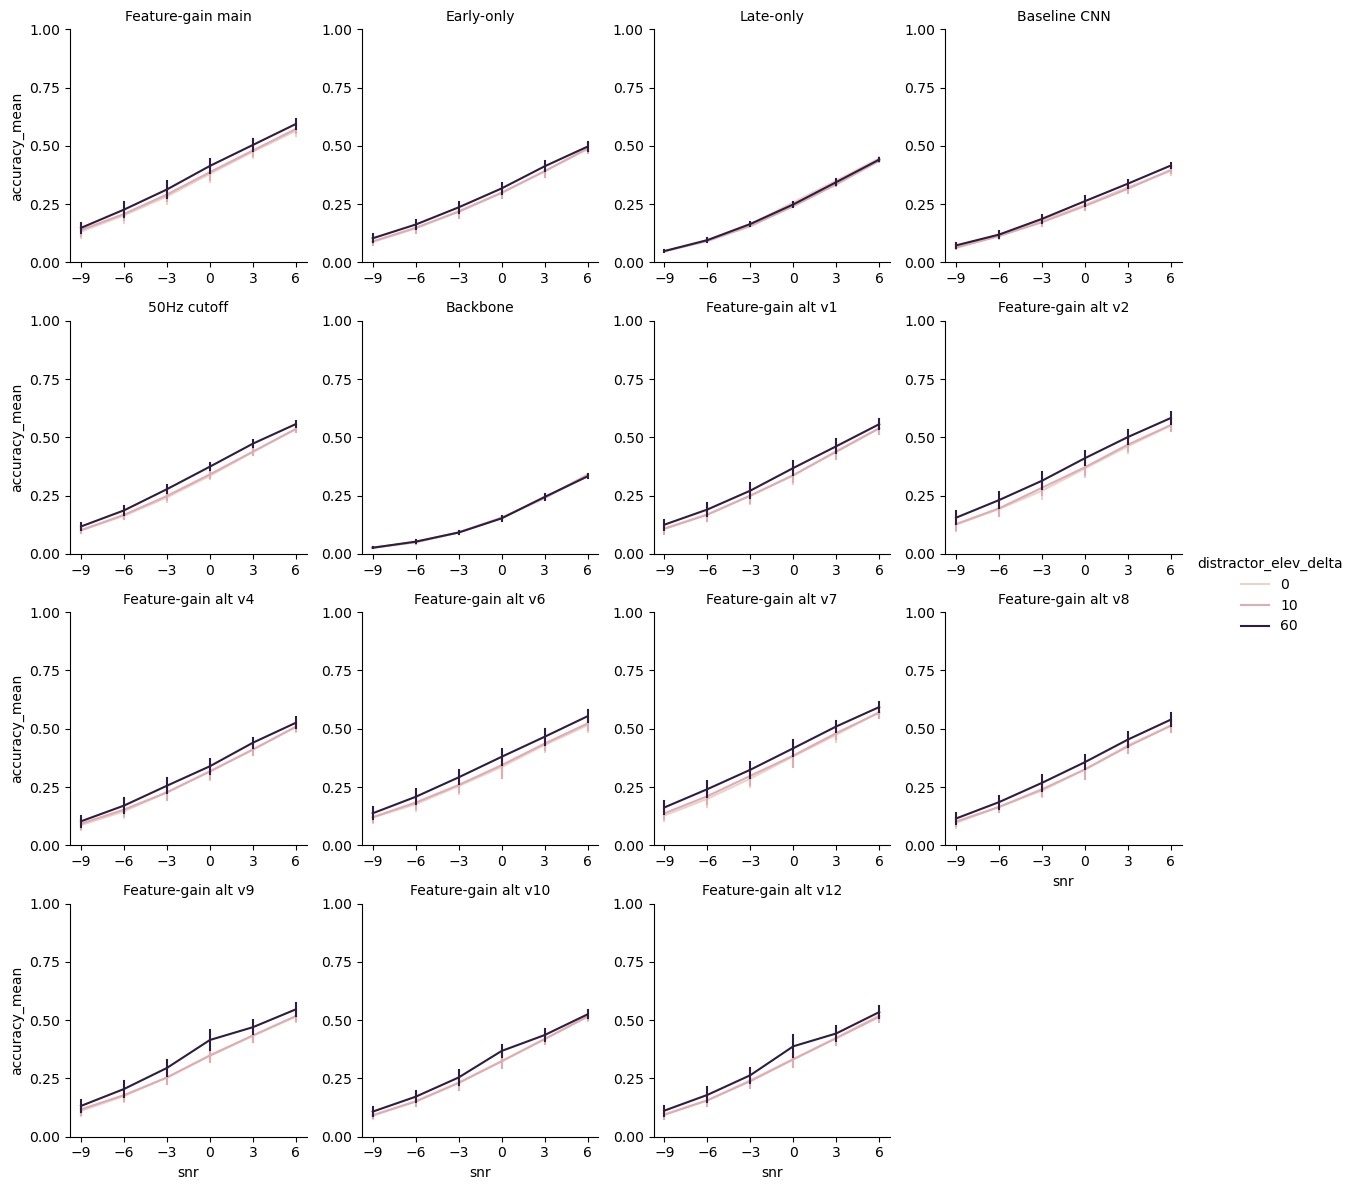

In [18]:
elev_to_plot = grouped_model_results[
                        (grouped_model_results.distractor_azim.eq(0 ))
                        & (grouped_model_results.snr.isin([6,3, 0, -3, -6, -9,]))

                            # & (grouped_model_results.distractor_azim.abs().isin([0,10, 60])) 
                            ].copy()

elev_to_plot.distractor_azim = elev_to_plot.distractor_azim.abs()                    


azim_thresholds = []
# p0 = [0.0, -4, 4]

all_models = grouped_model_results.model.unique()

model_order = ['Feature-gain main', 'Early-only','Late-only', "Baseline CNN", "50Hz cutoff", "Backbone"]
# nat sort the other archs 
also_sort = [m for m in all_models if m not in model_order]
model_order += sorted(also_sort, key=lambda x: int(re.search(r'\d+', x).group()))

model_order = [m for m in model_order if m in all_models]

plt.figure()
g = sns.relplot(data=elev_to_plot,
                x='snr', y='accuracy_mean', hue="distractor_elev_delta",
                kind='line', legend='full', facet_kws={"sharey":False, "sharex":False},
                col='model', col_wrap=4, col_order=model_order,
                # row='room_str',
                # palette=palette, 
                errorbar=('se', 1),
                err_style='bars',
                height=3, aspect=1)
g.set(xticks=np.arange(-9, 7, 3), yticks=[0, 0.25, 0.5, 0.75, 1])
g.set_titles(col_template="{col_name}")


In [19]:
grouped_model_results['azim_delta'] = (grouped_model_results['distractor_azim'] - grouped_model_results['target_azim']).abs()
grouped_model_results['elev_delta'] = (grouped_model_results['distractor_elev'] - grouped_model_results['target_elev']).abs()

In [20]:
# grouped_model_results

#### Summarize results for human-model similarity

In [21]:
## To save 
to_save = grouped_model_results[grouped_model_results.snr.isin([6,3, 0, -3, -6, -9,])].copy()
    
to_save = to_save.groupby(['model', 'snr', 'azim_delta', 'elev_delta']).agg({'accuracy_mean':['mean', 'sem'], "confusions_mean":['mean', 'sem']}).reset_index()
to_save.columns = ['model', 'snr', 'azim_delta', 'elev_delta', 'accuracy', 'accuracy_sem', 'confusions', 'confusions_sem']
to_save.loc[to_save.model.str.contains('main|gain'), 'group'] = 'Feature-gain Model'
to_save.loc[to_save.model.str.contains('Early'), 'group'] = 'Early-only'
to_save.loc[to_save.model.str.contains('Late'), 'group'] = 'Late-only'
to_save.loc[to_save.model.str.contains('Baseline'), 'group'] = 'Baseline CNN'
to_save.loc[to_save.model.str.contains('50Hz'), 'group'] = '50Hz cutoff'
to_save.loc[to_save.model.str.contains('Computed'), 'group'] = 'Computed-gain model'

fba_summary = grouped_model_results[grouped_model_results.model.str.contains('main|alt')].copy()
fba_per_model_summary = fba_summary.groupby(['model', 'snr', 'azim_delta', 'elev_delta']).agg({'accuracy_mean':['mean', 'sem'], "confusions_mean":['mean', 'sem']}).reset_index()
fba_per_model_summary.columns = ['model', 'snr', 'azim_delta', 'elev_delta', 'accuracy', 'accuracy_sem', 'confusions', 'confusions_sem']
fba_summary = fba_per_model_summary.groupby(['snr', 'azim_delta', 'elev_delta']).agg({'accuracy':['mean', 'sem'], "confusions":['mean', 'sem']}).reset_index()
# flatten multiindex
fba_summary.columns = ['snr', 'azim_delta', 'elev_delta', 'accuracy', 'accuracy_sem', 'confusions', 'confusions_sem']
# fba_summary['model'] = 'Feature-gain Model'
fba_summary['group'] = 'Feature-gain Model'


## Add human data to merge
good_part_results = pd.read_csv('final_results_dir/human_threshold_raw_data_N-33.csv')

good_part_results['azim_delta'] = (good_part_results['distractor_azim'] - good_part_results['target_azim']).abs()
part_summary = good_part_results.groupby(['snr', 'azim_delta', 'distractor_elev_delta']).agg({'correct_mean':['mean', 'sem'], "confusions_mean":['mean', 'sem']}).reset_index()
part_summary.columns = ['snr', 'azim_delta', 'elev_delta', 'accuracy', 'accuracy_sem', 'confusions', 'confusions_sem']
part_summary['model'] = 'Human (N=33)'
part_summary['group'] = 'Human (N=33)'
 


merge_indiv_models = pd.concat([to_save, part_summary], axis=0, ignore_index=True)
merge_fba_summary = pd.concat([to_save[to_save.model.str.contains("Early|Late|Baseline|50Hz|Computed")], fba_summary, part_summary], axis=0, ignore_index=True)

out_dir = Path('final_results_dir')


out_name = out_dir / f"df_for_stats_and_summary_2024_thresholds_humans_N-33_models_v10_w_control_50Hz_ECDF_models.pdpkl"
# merge_indiv_models.to_pickle(out_name)



# Plot practice effect using raw humna data

In [22]:
fba_per_model_summary.groupby('model').accuracy.mean().reset_index().agg({'accuracy':['mean', 'sem']}).reset_index()

,index,accuracy
0,mean,0.394667
1,sem,0.009115


In [23]:
raw_human_data.groupby(['participant', 'snr']).correct.mean().reset_index().groupby(['participant']).correct.max().mean()

0.7800925043587518

In [24]:
### 80 trials per block. First block is trial num < 80. Last block is trial num <= 400. 
practice_effect_df = raw_human_data.copy()
# digitize trial number into 6 bins 
block_cutoffs = np.arange(0, 480, 80)
practice_effect_df['exp_block'] = np.digitize(practice_effect_df.trial_num, block_cutoffs, right=False)
# practice_effect_df = practice_effect_df[practice_effect_df.exp_block.isin([1,6])]
practice_effect_df = practice_effect_df.groupby(['participant', 'exp_block']).correct.mean().reset_index()
# sns.lineplot(data=practice_effect_df, x='exp_block', y='correct', errorbar=('se', 1))

In [35]:
fba_per_model_summary.to_csv('final_results_to_share/experiment_6_fba_model_summary.csv', index=False)

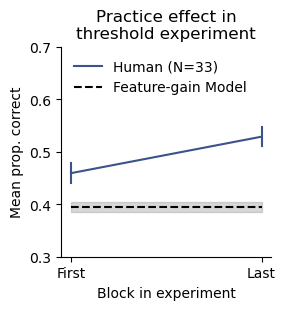

In [33]:
### Simplify practice effect plot
model_acc_mean, model_acc_sem = fba_per_model_summary.groupby('model').accuracy.mean().reset_index().agg({'accuracy':['mean', 'sem']}).values

block_ixs = [1,6] # first and last 
to_plot = practice_effect_df[practice_effect_df.exp_block.isin(block_ixs)]

human_color = sns.color_palette("viridis", as_cmap=True)(0.25)



g = sns.relplot(data=to_plot, x='exp_block', y='correct',
            # hue='azim_delta', # hue_order=hue_order,
            errorbar=('se', 1),err_style='bars',
            height=3,
            color=human_color,
            kind='line', aspect=1)
g.set(xticks=block_ixs, xticklabels=['First', 'Last'], )
# add error bar for model mean accuracy
ax = g.axes[0,0]
ax.plot(block_ixs, [model_acc_mean, model_acc_mean], '--k')
ax.set_ylim(0.3, .7)
# ax.set_yticks(np.arange(0.35, 0.75, 0.1))

## Add legend manually 

legend_handles = [
    Line2D([0], [0], marker='', color=human_color,
           label=f"Human (N={N})",
           markerfacecolor=human_color,
           )
           ,   
        Line2D([0], [0], ls='--', color='k',
           label=f"Feature-gain Model",
           markerfacecolor='k',
           )
            ]

fontsize=10

color_legend = ax.legend(handles=legend_handles, title="", frameon=False,
                              loc='upper left', fontsize=fontsize, title_fontsize=fontsize,
                              bbox_to_anchor=(0, 1),
                            #   bbox_transform=fig.transFigure
                              ) 
ax.fill_between(block_ixs, model_acc_mean + model_acc_sem,  model_acc_mean - model_acc_sem, alpha=0.3, color='grey')
# g.fig.suptitle(f"Accuracy improvement over experiment (N={N})", y=1.05)
g.set_axis_labels("Block in experiment", "Mean prop. correct")
# g.legend.set_title("Azimuth\noffset\n(degrees)")
ax.set_title('Practice effect in\nthreshold experiment', fontsize=12,)

## Make panel aspect square 
ratio = 1.0 
xleft, xright = ax.get_xlim()
ybottom, ytop = ax.get_ylim()
ax.set_aspect(abs((xright-xleft)/(ybottom-ytop))*ratio)
# g.savefig(fig_out_dir / "figure_4_threshold_practice_effect.pdf", transparent=True, bbox_inches='tight')

# Plot main results

In [26]:
## Fit model thresholds per texture level 
np.random.seed(0)
n_boots = 10_000  ## use 10_000 for final analysis

model_thresholds = []
model_bootstrap_thresholds = []

### Bootstrap over alt archs 
control_str = "Early|Late|Baseline|50Hz|Computed|Backbone"
fba_models_for_thresholds = grouped_model_results[~grouped_model_results.model.str.contains(control_str)].copy()

n_models = fba_models_for_thresholds.model.nunique()

# Fit thresholds to average over models 
model_thresh_lim = fba_models_for_thresholds.accuracy_mean.max() * .5
for (dist_azim, dist_elev), data in fba_models_for_thresholds.groupby(['azim_delta', 'elev_delta']):
    results_for_thresh = data.groupby('snr').agg({'accuracy_mean':'mean'}).reset_index()
    thresh, ploy = util_analysis.estimate_threshold_poly(results_for_thresh.snr.values, results_for_thresh.accuracy_mean.values, degree=2, threshold=model_thresh_lim)
    model_thresholds.append({'azim_delta':dist_azim, 'elev_delta':dist_elev, 'threshold':thresh})

# # Bootstrap error over estimate

for (dist_azim, dist_elev), data in fba_models_for_thresholds.groupby(['azim_delta', 'elev_delta']):
    for i in tqdm(range(n_boots)):
        model_sample  = np.random.choice(fba_models_for_thresholds.model.unique(), size=n_models, replace=True)
        sample_data = pd.concat([data[data.model == model] for model in model_sample], axis=0, ignore_index=True).reset_index()
        results_for_thresh = sample_data.groupby('snr').agg({'accuracy_mean':'mean'}).reset_index()
        # try:
        thresh, poly = util_analysis.estimate_threshold_poly(results_for_thresh.snr.values, 
                                                             results_for_thresh.accuracy_mean.values,
                                                             degree=2,
                                                             threshold=model_thresh_lim)
        # except:
            # thresh = 6 # set to max snr tested
        model_bootstrap_thresholds.append({
                        'texture_level':texture_level, 'azim_delta':dist_azim, 'elev_delta':dist_elev, "sex_cond":sex_cond,
                        'threshold':thresh})

model_thresh_df = pd.DataFrame(model_bootstrap_thresholds)

raw_thresholds = pd.DataFrame.from_records(model_thresholds)
raw_thresholds.rename(columns={'threshold':'threshold_raw'}, inplace=True)

model_thresh_df_summary = model_thresh_df.groupby(['elev_delta', 'azim_delta']).agg({'threshold':['mean','std']}).reset_index()
# # flatten multiindex
model_thresh_df_summary.columns = ['elev_delta', 'azim_delta', 'threshold', 'threshold_std']

model_thresh_df_summary = model_thresh_df_summary.merge(raw_thresholds, on=['elev_delta', 'azim_delta'], how='left')

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

In [ ]:
# model_thresh_df_summary.to_csv('final_results_to_share/experiment_6_model_thresholds.csv', index=False)

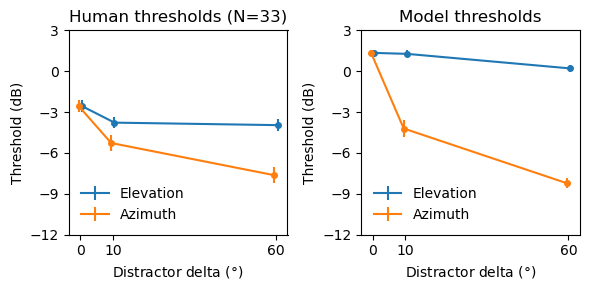

In [31]:
#### Per sex 
fig, axs = plt.subplots(1,2,figsize=(6,3))


for ix, ax in enumerate(axs):
    if ix == 0:
        elev_data = human_thresh_df_summary[human_thresh_df_summary.azim_delta == 0]
        azim_data = human_thresh_df_summary[human_thresh_df_summary.elev_delta == 0]
    elif ix == 1: 
        elev_data = model_thresh_df_summary[(model_thresh_df_summary.azim_delta == 0)] #& (model_thresh_df_summary.model.str.contains('v10'))]
        azim_data = model_thresh_df_summary[(model_thresh_df_summary.elev_delta == 0)]# & (model_thresh_df_summary.model.str.contains('v10'))]
    elev_to_plot = elev_data
    azim_to_plot = azim_data
  
    ax.errorbar(data=elev_to_plot, x=elev_to_plot.elev_delta + 0.5, y='threshold', yerr='threshold_std', fmt='o-', label='Elevation', markersize=4)
    ax.errorbar(data=azim_to_plot, x=azim_to_plot.azim_delta - 0.5, y='threshold', yerr='threshold_std', fmt='o-', label='Azimuth',markersize=4)

    ax.legend(loc='lower left', markerscale=0)
    ax.get_legend().get_frame().set_linewidth(0.0)

    ax.set_xlabel('Distractor delta ($\degree$)')
    ax.set_ylabel('Threshold (dB)')
    ax.set_xticks([0, 10, 60])
    ax.set_yticks(np.arange(-12, 4, 3))
    if ix == 0:
        ax.set_title(f"Human thresholds (N={N})" )
    elif ix == 1:
        ax.set_title("Model thresholds" )

plt.tight_layout()
# plt.savefig(fig_out_dir / "figure_4_model_thresholds.pdf", transparent=True, bbox_inches='tight')

In [28]:
## Fit model thresholds per texture level 
np.random.seed(0)
n_boots = 1_000  ## use 10_000 for final analysis

model_thresholds = []

### Bootstrap over alt archs 

n_models = grouped_model_results.model.nunique()

for (dist_azim, dist_elev), data in grouped_model_results.groupby(['azim_delta', 'elev_delta']):
    for i in tqdm(range(n_boots)):
        model_sample  = np.random.choice(grouped_model_results.model.unique(), size=n_models, replace=True)
        sample_data = pd.concat([data[data.model == model] for model in model_sample], axis=0, ignore_index=True).reset_index()
        results_for_thresh = sample_data.groupby('snr').agg({'accuracy_mean':'mean'}).reset_index()
        # try:
        thresh, poly = util_analysis.estimate_threshold_poly(results_for_thresh.snr.values, results_for_thresh.accuracy_mean.values, degree=2)
        # except:
            # thresh = 6 # set to max snr tested
        model_thresholds.append({
                        'model':model, 'texture_level':texture_level, 'azim_delta':dist_azim, 'elev_delta':dist_elev, "sex_cond":sex_cond,
                        'threshold':thresh})

model_thresh_df = pd.DataFrame(model_thresholds)

  0%|          | 0/1000 [00:00<?, ?it/s]

NameError: name 'model' is not defined

In [29]:
model_thresh_df

,texture_level,azim_delta,elev_delta,sex_cond,threshold
0,30,0,0,different,4.933934
1,30,0,0,different,5.114114
2,30,0,0,different,4.828829
3,30,0,0,different,4.948949
4,30,0,0,different,4.933934
...,...,...,...,...,...
4995,30,60,0,different,-5.006006
4996,30,60,0,different,-4.300300
4997,30,60,0,different,-5.066066
4998,30,60,0,different,-3.669670


In [30]:

model_thresh_df_summary = model_thresh_df.groupby(['elev_delta', 'azim_delta']).agg({'threshold':['mean','std']}).reset_index()
# # flatten multiindex
model_thresh_df_summary.columns = ['elev_delta', 'azim_delta', 'threshold', 'threshold_std']


# model_thresh_df_summary_per_sex = model_thresh_df_sex_cond.groupby(['model', 'elev_delta', 'azim_delta', 'sex_cond']).agg({'threshold':['mean', 'std']}).reset_index()
# # # flatten multiindex
# model_thresh_df_summary_per_sex.columns = ['model', 'elev_delta', 'azim_delta', 'sex_cond', 'threshold', 'threshold_std']


In [35]:
raw_thresholds = pd.DataFrame.from_records(model_thresholds)
raw_thresholds.rename(columns={'threshold':'threshold_raw'}, inplace=True)
raw_thresholds.drop(columns=['texture_level'], inplace=True)

KeyError: "['texture_level'] not found in axis"

In [ ]:
model_thresh_df_summary

,elev_delta,azim_delta,threshold,threshold_std
0,0,0,4.980871,0.211373
1,0,10,-0.113288,0.626166
2,0,60,-4.503453,0.405980
3,10,0,4.953138,0.226902
4,60,0,4.120435,0.253800


In [32]:
## Add raw thresholds to df summary 
model_thresh_df_summary = model_thresh_df_summary.merge(raw_thresholds, on=['elev_delta', 'azim_delta'], how='left')
model_thresh_df_summary

KeyError: 'elev_delta'

#### Plot main human v model 

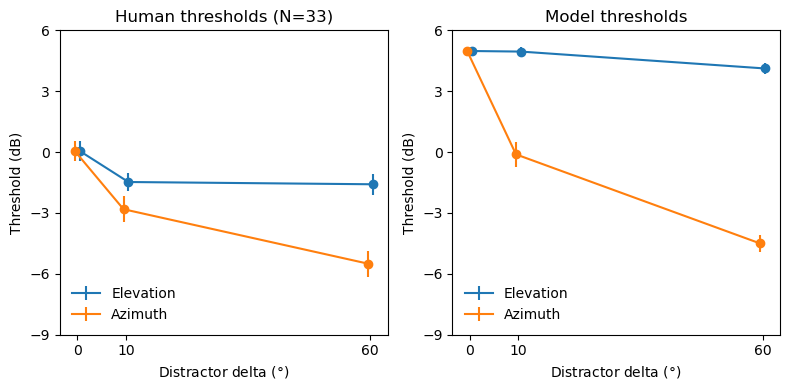

In [38]:
model_thresh_df_summary

,elev_delta,azim_delta,threshold,threshold_std
0,0,0,4.731021,0.242195
1,0,10,-0.648634,0.427399
2,0,60,-4.594880,0.369980
3,10,0,4.845721,0.256185
4,60,0,3.966937,0.291467


AttributeError: 'DataFrame' object has no attribute 'model'

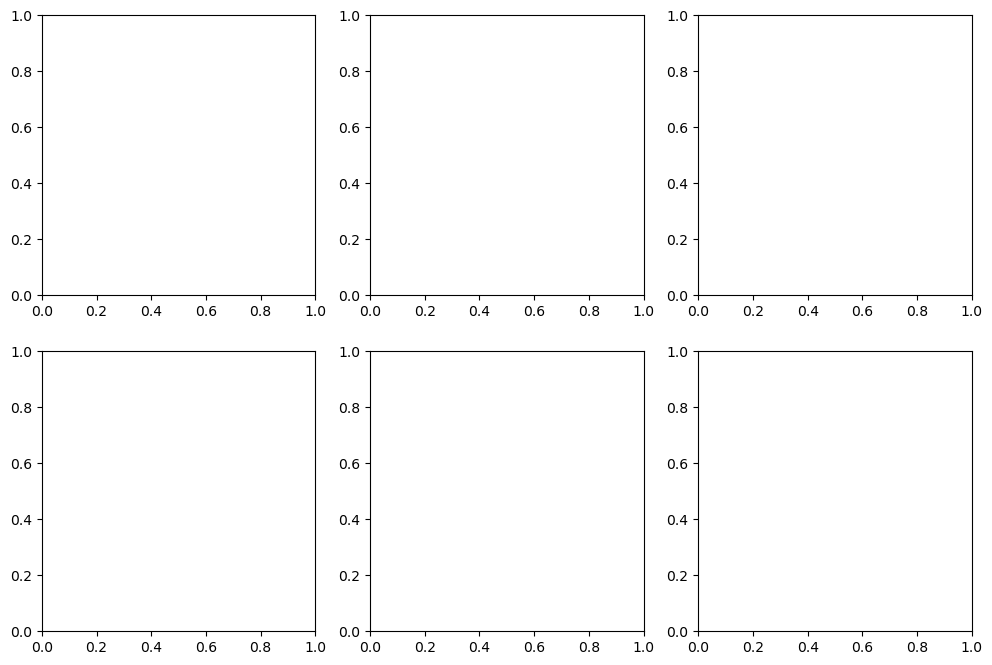

In [39]:
#### Per sex 
fig, ax = plt.subplots(2,3,figsize=(12,8))


sex_conds = ['all', 'same', 'different']
for jx, model in enumerate(model_thresh_df_summary.model.unique()):
    for ix, sex_cond in enumerate(sex_conds):
        if ix == 0:
            elev_data = model_thresh_df_summary[(model_thresh_df_summary.azim_delta == 0) & (model_thresh_df_summary.model == model)]
            azim_data = model_thresh_df_summary[(model_thresh_df_summary.elev_delta == 0) & (model_thresh_df_summary.model == model)]
            elev_to_plot = elev_data
            azim_to_plot = azim_data
        else: 
            elev_data = model_thresh_df_summary_per_sex[(model_thresh_df_summary_per_sex.azim_delta == 0)  & (model_thresh_df_summary_per_sex.model == model)]
            azim_data = model_thresh_df_summary_per_sex[(model_thresh_df_summary_per_sex.elev_delta == 0)  & (model_thresh_df_summary_per_sex.model == model)]
            elev_to_plot = elev_data[elev_data.sex_cond == sex_cond]
            azim_to_plot = azim_data[azim_data.sex_cond == sex_cond]

        ax[jx, ix].errorbar(data=elev_to_plot, x=elev_to_plot.elev_delta + 0.5, y='threshold', yerr='threshold_std', fmt='o-', label='Elevation')
        ax[jx, ix].errorbar(data=azim_to_plot, x=azim_to_plot.azim_delta - 0.5, y='threshold', yerr='threshold_std', fmt='o-', label='Azimuth')

        ax[jx, ix].legend(loc='lower left', markerscale=0)
        ax[jx, ix].get_legend().get_frame().set_linewidth(0.0)

        ax[jx, ix].set_xlabel('Distractor delta ($\degree$)')
        ax[jx, ix].set_ylabel('Threshold (dB)')
        ax[jx, ix].set_xticks([0, 10, 60])
        ax[jx, ix].set_yticks(np.arange(-9, 7, 3))
        if ix == 0:
            ax[jx, ix].set_title(f"{model}\nAll trials")
        else:
            ax[jx, ix].set_title(f"{model}\n{sex_cond.title()} sex trials")

    plt.suptitle(f"Model thresholds", y=1.01)
plt.tight_layout()

### Look at accuracy v snr traces:


In [33]:
good_part_results = pd.read_csv('final_results_dir/human_threshold_raw_data_N-33.csv')
good_part_results.head()

,participant,target_azim,target_elev,distractor_azim,distractor_elev_delta,snr,n_distractors,correct_mean,correct_sem,confusions_mean,confusions_sem,confusions_count
0,participant_001,0,40,-60,0,-9,2,0.1875,0.100778,0.5625,0.128087,16
1,participant_001,0,40,-60,0,-6,2,0.3125,0.119678,0.2500,0.111803,16
2,participant_001,0,40,-60,0,-3,2,0.4375,0.128087,0.0625,0.062500,16
3,participant_001,0,40,-60,0,0,2,0.5625,0.128087,0.0000,0.000000,16
4,participant_001,0,40,-60,0,3,2,0.8750,0.085391,0.0000,0.000000,16


In [ ]:

# put humans and model in same dataframe. Change correct to accuracy in column names 
grouped_model_results.rename(columns={'accuracy_mean':'correct_mean', 'accuracy_sem':'correct_sem',}, inplace=True)
grouped_model_results_to_merge = grouped_model_results.copy()
good_part_results.rename(columns={'azim_delta':'distractor_azim', 'elev_delta':'distractor_elev_delta'}, inplace=True)


grouped_model_results['group'] = grouped_model_results['model']
N = good_part_results.participant.nunique()
good_part_results['group'] = f'Humans (N={N})'



merged_results = pd.concat([grouped_model_results, good_part_results], ignore_index=True, axis=0)

# N = good_part_results.participant.nunique()
# good_part_results['group'] = f'Humans (N={N})'
# merged_results = pd.concat([grouped_model_results, good_part_results], ignore_index=True, axis=0)



# N = good_part_results.participant.nunique()
# good_part_results['group'] = f'Humans (N={N})'


# merged_good_parts = merged_results[merged_results.participant.isin(good_parts)]

In [ ]:
merged_results.group.unique()

array(['word_task_v09_cue_loc_task',
       'word_task_v10_main_feature_gain_config', 'Humans (N=33)'],
      dtype=object)

Text(0.5, 1.05, 'Azimuth performance')

<Figure size 640x480 with 0 Axes>

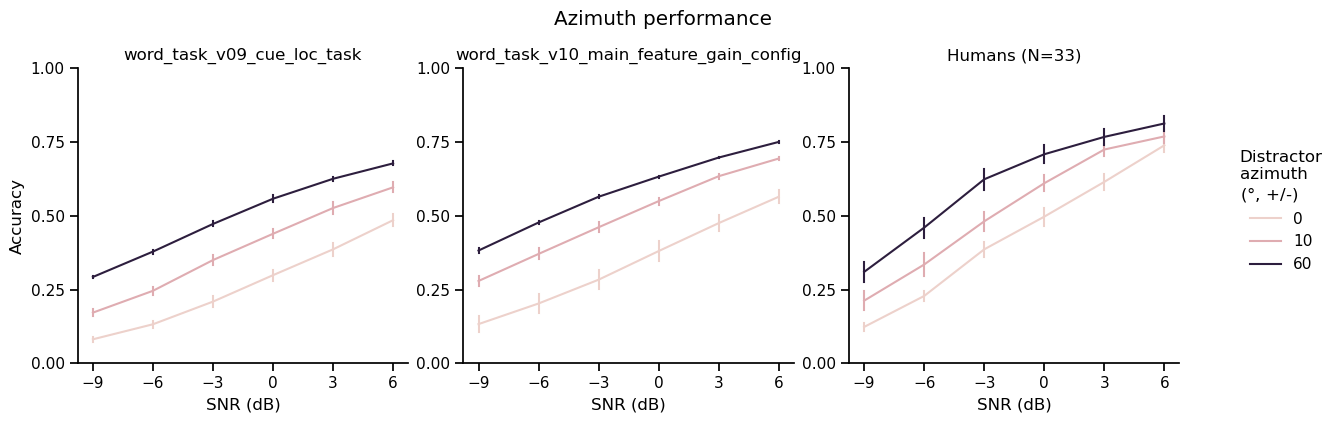

In [ ]:


## First, get grand average. Then bootstrap for error 
sns.set_context('notebook')

# avg threshold estimates for 0 and 10 azimuth separation 
to_plot = merged_results[
                                        # (merged_results.n_distractors == 2)
                                                #   & (merged_results.room_str == 'Min. reverb speaker array')
                                                (merged_results.distractor_elev_delta.eq(0 ))
                                                 & (merged_results.distractor_azim.abs().isin([0,10, 60])) 
                                                #   & (merged_results.snr.isin([6,3, 0, -3, -6, -9,]))
                                                    ].copy()

to_plot.distractor_azim = to_plot.distractor_azim.abs()                    
azim_results_for_thresh = to_plot.groupby(['model','room_str', 'distractor_azim', 'snr']).agg({'correct_mean':'mean'}).reset_index()



azim_thresholds = []
# p0 = [0.0, -4, 4]
# for (model, room, dist_type, azim), group in azim_results_for_thresh.groupby(['model', 'room_str', 'distractor_type', 'distractor_azim']): #, 'gender_cond']):
#     thresh, fit_popt, _ = util_analysis.estimate_thresholds(group.snr.values, group.correct_mean.values, bounds_from_data=True)#, p0=p0)
#     if np.isnan(thresh):
#         print(f"Threshold is nan for azim {azim}")
#     azim_thresholds.append({'model': model, "room":room, "dist_type":dist_type, 'azim': azim, 'threshold':thresh}) #  'gender_cond':gend_cond,
        
# azim_thresh_df = pd.DataFrame(azim_thresholds)

# col_order = [f'Humans (N={N})', "Model"]

plt.figure()
g = sns.relplot(data=to_plot[to_plot.snr.isin([6,3, 0, -3, -6, -9,])],
                                x='snr', y='correct_mean', hue="distractor_azim",
                                kind='line', legend='full', facet_kws={"sharey":False, "sharex":False},
                                col='group', #col_order=col_order,
                                # row='room_str',
                                # palette=palette, 
                                errorbar=('se', 1),
                                err_style='bars',
                                height=4, aspect=1)

g.set_axis_labels("SNR (dB)", "Accuracy")
# set legend title 
new_title = 'Distractor\nazimuth\n($\degree$, +/-)'
g._legend.set_title(new_title)
# set xticks from -9 to 6
g.set(xticks=np.arange(-9, 7, 3), yticks=[0, 0.25, 0.5, 0.75, 1])
# column titles 
g.set_titles("{col_name}")
plt.suptitle(f'Azimuth performance', y=1.05)
# plt.tight_layout()

<Figure size 640x480 with 0 Axes>

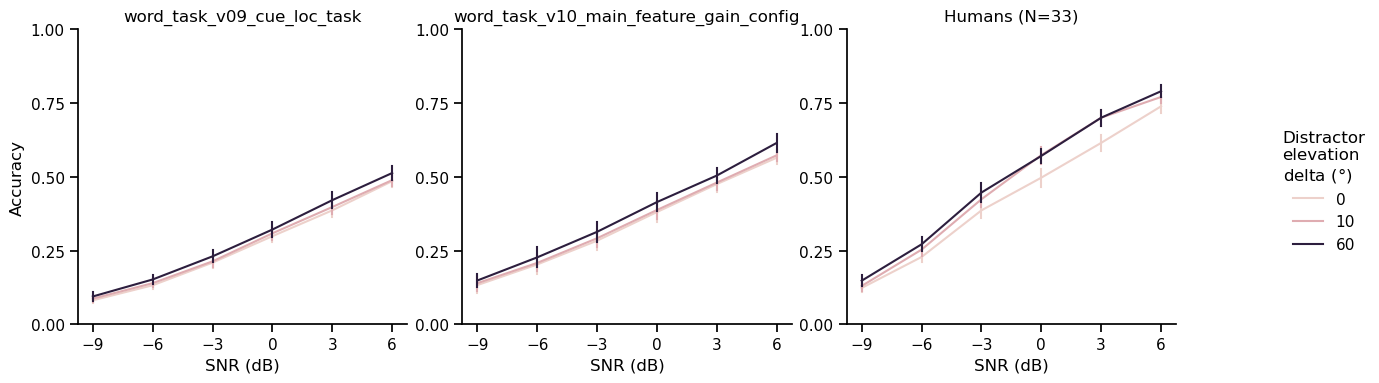

In [ ]:
to_plot = merged_results[
                    (merged_results.n_distractors == 2)
                        #   & (merged_results.room_str == 'Min. reverb speaker array')
                        # & (merged_results.distractor_elev_delta.isin([0,10,60]))
                        &	(merged_results.distractor_azim == 0) 
                        &	(merged_results.target_elev != 0) 

                        #   & (merged_results.snr.isin([6,3, 0, -3, -6, -9,]))
                          ].copy()

# to_plot.distractor_azim = to_plot.distractor_azim.abs()                    
# azim_results_for_thresh = to_plot.groupby(['model','room_str', 'distractor_azim', 'distractor_type', 'snr']).agg({'correct_mean':'mean'}).reset_index()



# azim_thresholds = []
# p0 = [0.0, -4, 4]
# for (model, room, dist_type, azim), group in azim_results_for_thresh.groupby(['model', 'room_str', 'distractor_type', 'distractor_azim']): #, 'gender_cond']):
#     thresh, fit_popt, _ = util_analysis.estimate_thresholds(group.snr.values, group.correct_mean.values, bounds_from_data=True)#, p0=p0)
#     if np.isnan(thresh):
#         print(f"Threshold is nan for azim {azim}")
#     azim_thresholds.append({'model': model, "room":room, "dist_type":dist_type, 'azim': azim, 'threshold':thresh}) #  'gender_cond':gend_cond,
    
# azim_thresh_df = pd.DataFrame(azim_thresholds)


plt.figure()
g = sns.relplot(data=to_plot[to_plot.snr.isin([6,3, 0, -3, -6, -9,])],
                x='snr', y='correct_mean', hue="distractor_elev_delta",
                kind='line', legend='full', facet_kws={"sharey":False, "sharex":False},
                col='group', 
                # row='room_str',
                # palette=palette, 
                errorbar=('se', 1),
                err_style='bars',
                height=4, aspect=1)
g.set_axis_labels("SNR (dB)", "Accuracy")
# set legend title 
new_title = 'Distractor\nelevation\ndelta ($\degree$)'
g._legend.set_title(new_title)
# set xticks from -9 to 6
g.set(xticks=np.arange(-9, 7, 3), yticks=[0, 0.25, 0.5, 0.75, 1])
# column titles 
g.set_titles("{col_name}")
# plt.suptitle(f'Model elevation performance', y=1.05)

<Figure size 640x480 with 0 Axes>

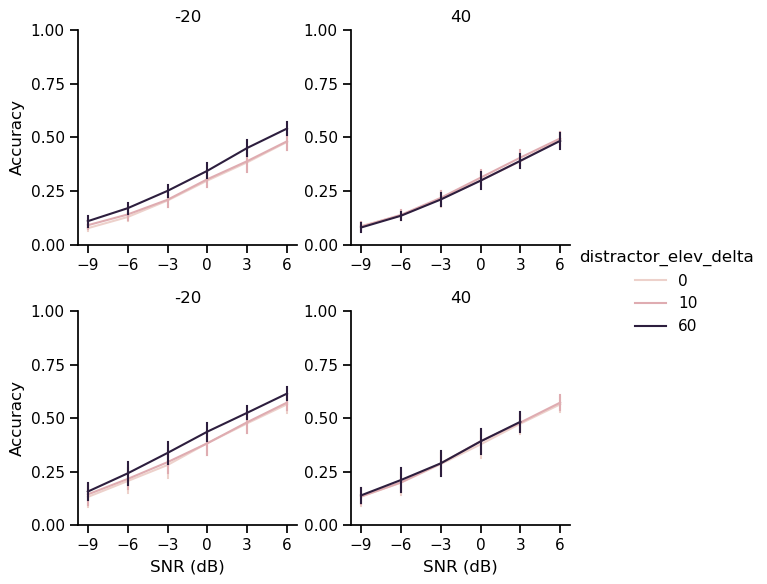

In [ ]:
to_plot = merged_results[
                    (merged_results.n_distractors == 2)
                    & (merged_results.group != 'Humans (N=33)')
                        #   & (merged_results.room_str == 'Min. reverb speaker array')
                        # & (merged_results.distractor_elev_delta.isin([0,10,60]))
                    &	(merged_results.distractor_azim == 0) 
                    &	(merged_results.target_elev != 0) 

                        #   & (merged_results.snr.isin([6,3, 0, -3, -6, -9,]))
                          ].copy()

# to_plot.distractor_azim = to_plot.distractor_azim.abs()                    
# azim_results_for_thresh = to_plot.groupby(['model','room_str', 'distractor_azim', 'distractor_type', 'snr']).agg({'correct_mean':'mean'}).reset_index()



# azim_thresholds = []
# p0 = [0.0, -4, 4]
# for (model, room, dist_type, azim), group in azim_results_for_thresh.groupby(['model', 'room_str', 'distractor_type', 'distractor_azim']): #, 'gender_cond']):
#     thresh, fit_popt, _ = util_analysis.estimate_thresholds(group.snr.values, group.correct_mean.values, bounds_from_data=True)#, p0=p0)
#     if np.isnan(thresh):
#         print(f"Threshold is nan for azim {azim}")
#     azim_thresholds.append({'model': model, "room":room, "dist_type":dist_type, 'azim': azim, 'threshold':thresh}) #  'gender_cond':gend_cond,
    
# azim_thresh_df = pd.DataFrame(azim_thresholds)


plt.figure()
g = sns.relplot(data=to_plot[to_plot.snr.isin([6,3, 0, -3, -6, -9,])],
                x='snr', y='correct_mean', hue="distractor_elev_delta",
                kind='line', legend='full', facet_kws={"sharey":False, "sharex":False},
                col='target_elev', 
                row='group',
                # palette=palette, 
                errorbar=('se', 1),
                err_style='bars',
                height=3, aspect=1)
g.set_axis_labels("SNR (dB)", "Accuracy")
# set legend title 
new_title = 'Distractor\nelevation\ndelta ($\degree$)'
# g._legend.set_title(new_title)
# set xticks from -9 to 6
g.set(xticks=np.arange(-9, 7, 3), yticks=[0, 0.25, 0.5, 0.75, 1])
# column titles 
g.set_titles("{col_name}")
# plt.suptitle(f'Model elevation performance', y=1.05)

<Figure size 640x480 with 0 Axes>

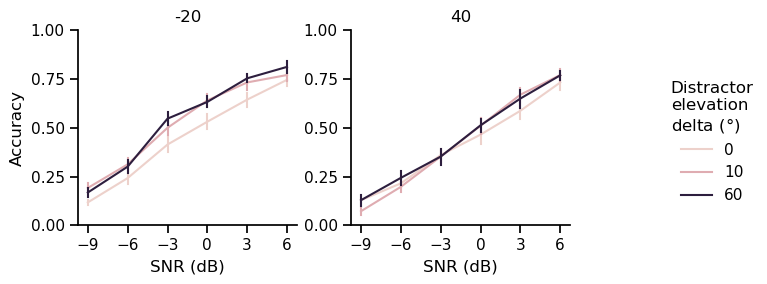

In [ ]:
to_plot = merged_results[
                    (merged_results.n_distractors == 2)
                    & (merged_results.group.str.contains('Human'))
                        #   & (merged_results.room_str == 'Min. reverb speaker array')
                        # & (merged_results.distractor_elev_delta.isin([0,10,60]))
                        &	(merged_results.distractor_azim == 0) 
                        #   & (merged_results.snr.isin([6,3, 0, -3, -6, -9,]))
                          ].copy()

# to_plot.distractor_azim = to_plot.distractor_azim.abs()                    
# azim_results_for_thresh = to_plot.groupby(['model','room_str', 'distractor_azim', 'distractor_type', 'snr']).agg({'correct_mean':'mean'}).reset_index()



# azim_thresholds = []
# p0 = [0.0, -4, 4]
# for (model, room, dist_type, azim), group in azim_results_for_thresh.groupby(['model', 'room_str', 'distractor_type', 'distractor_azim']): #, 'gender_cond']):
#     thresh, fit_popt, _ = util_analysis.estimate_thresholds(group.snr.values, group.correct_mean.values, bounds_from_data=True)#, p0=p0)
#     if np.isnan(thresh):
#         print(f"Threshold is nan for azim {azim}")
#     azim_thresholds.append({'model': model, "room":room, "dist_type":dist_type, 'azim': azim, 'threshold':thresh}) #  'gender_cond':gend_cond,
    
# azim_thresh_df = pd.DataFrame(azim_thresholds)


plt.figure()
g = sns.relplot(data=to_plot[to_plot.snr.isin([6,3, 0, -3, -6, -9,])],
                x='snr', y='correct_mean', hue="distractor_elev_delta",
                kind='line', legend='full', facet_kws={"sharey":False, "sharex":False},
                col='target_elev', 
                # row='room_str',
                # palette=palette, 
                errorbar=('se', 1),
                err_style='bars',
                height=3, aspect=1)
g.set_axis_labels("SNR (dB)", "Accuracy")
# set legend title 
new_title = 'Distractor\nelevation\ndelta ($\degree$)'
g._legend.set_title(new_title)
# set xticks from -9 to 6
g.set(xticks=np.arange(-9, 7, 3), yticks=[0, 0.25, 0.5, 0.75, 1])
# column titles 
g.set_titles("{col_name}")
# plt.suptitle(f'Model elevation performance', y=1.05)